In [35]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Data Management
import pandas as pd
import numpy as np
#from ta import add_all_ta_features
from itertools import product
from functools import reduce

import datetime as dt
from dateutil.relativedelta import relativedelta
import yfinance as yf

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Binary Classification Specific Metrics
from sklearn.metrics import RocCurveDisplay

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Statistics
from statsmodels.tsa.stattools import adfuller

# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

# Supervised Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Optimalization
from scipy.optimize import minimize
from scipy.optimize import brute

# PCA - Principal Component Analysis
from sklearn.decomposition import PCA

# Path
from os.path import exists as file_exists

# Indicators
import Indicators_and_ToolsClasses as indicators


### Class PrepareData

In [36]:
class PrepareData():
    def __init__(self, symbol, start, end, interval = "1d", train_ratio = 0.9, stationary = True):
        
        self.symbol = symbol
        self.start = start
        self.end = end
        self.interval = interval
        self.train_ratio = train_ratio

        self.raw_data = pd.DataFrame()
        self.calculated_data = pd.DataFrame()
        self.all_data = pd.DataFrame() 

        self.start_get_data()

        if stationary == True:
            self.prepare_stationary_data()
        else:
            self.prepare_non_stationary_data()

    def get_data(self, start, end):
        data = yf.download(self.symbol, start, end, interval = self.interval, ignore_tz = True)
        data.dropna(inplace=True)
        data.drop(columns=data.columns[data.eq(0).any().tolist()], inplace=True)
        return data
    
    def start_get_data(self):
        if not file_exists(f"CSV_data/{self.symbol}_D.csv"):
            self.raw_data = self.get_data(self.start, self.end)
            self.raw_data.to_csv(f"CSV_data/{self.symbol}_D.csv")      
        else:
            self.raw_data = pd.read_csv(f"CSV_data/{self.symbol}_D.csv")
            self.raw_data.set_index("Date", inplace=True)

            str_time_index = self.raw_data.index[0]
            self.time_index = dt.datetime.strptime(str_time_index, '%Y-%m-%d')
        
        self.all_data = self.raw_data.copy()
        self.calculated_data = self.calculate_indicators(self.raw_data)
        self.all_data = pd.merge(self.all_data, self.calculated_data, left_index=True, right_index=True)

    def calculate_indicators(self, raw_data):       
            # MA:
            if not file_exists(f"CSV_data/MA_D.csv"):
                data_MA = {}
                for i in range(3, 201):
                    data_MA[f"SMA-{i}"] = indicators.Moving_Averages("SMA", i, raw_data["Close"]).result["{}-{}".format("SMA", i)]
                
                for i in range(3, 201):
                    data_MA[f"EMA-{i}"] = indicators.Moving_Averages("EMA", i, raw_data["Close"]).result["{}-{}".format("EMA", i)]

                for i in range(3, 201):
                    data_MA[f"HMA-{i}"] = indicators.Moving_Averages("HMA", i, raw_data["Close"]).result["{}-{}".format("HMA", i)]
                
                
                self.MA = pd.DataFrame.from_dict(data_MA)
                self.MA.dropna(inplace=True)
                self.MA.to_csv(f"CSV_data/MA_D.csv")
            else:
                self.MA = pd.read_csv(f"CSV_data/MA_D.csv")
                self.MA.set_index("Date", inplace=True)
            
            calculated_data = self.MA
            calculated_data = calculated_data.T.drop_duplicates().T
            return calculated_data 

    def prepare_stationary_data(self):

        self.all_data = self.all_data.drop(columns=self.all_data.columns[self.all_data.eq(0).any().tolist()])
        # Identify non-stationary columns
        non_stationaries = []
        for col in self.all_data.columns:
            dftest = adfuller(self.all_data["{}".format(col)].values)
            p_value = dftest[1]
            t_test = dftest[0] < dftest[4]["1%"]
            if p_value > 0.05 or not t_test:
                non_stationaries.append(col)
        
        # Convert non-stationaries to stationary
        self.df_stationary = self.all_data.copy()
        self.df_stationary[non_stationaries] = self.df_stationary[non_stationaries].pct_change()
        self.df_stationary = self.df_stationary.iloc[1:]

        # Find NaN Rows
        na_list = self.df_stationary.columns[self.df_stationary.isna().any().tolist()]
        self.df_stationary.drop(columns=na_list, inplace=True)

        # Handle inf values
        self.df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
        
        self.all_data["HMA-3-TARGET"] = indicators.Moving_Averages("HMA", 3, self.all_data["Close"]).result["{}-{}".format("HMA", 3)]
        # Set Target
        self.df_stationary["TARGET"] = 0
        #self.df_stationary.loc[self.data["Close"].shift(-1) > self.data["Close"], "TARGET"] = 1
        self.df_stationary.loc[self.all_data["HMA-3-TARGET"].shift(-1) > self.all_data["HMA-3-TARGET"], "TARGET"] = 1
        self.df_stationary.dropna(inplace=True)

        # Split Target from Featureset
        self.X = self.df_stationary.iloc[:, :-1]
        self.y = self.df_stationary.iloc[:, -1]

        # Feature Scaling
        self.X_fs = StandardScaler().fit_transform(self.X)

        self.prepare_data(self.X_fs)

        self.full_data_X.to_csv(f"CSV_data/Xy_stationary/full_data_X.csv")
        self.X_train.to_csv(f"CSV_data/Xy_stationary/X_train.csv")
        self.X_test.to_csv(f"CSV_data/Xy_stationary/X_test.csv")
        self.y_train.to_csv(f"CSV_data/Xy_stationary/y_train.csv")
        self.y_test.to_csv(f"CSV_data/Xy_stationary/y_test.csv")

    def prepare_non_stationary_data(self):

        # self.all_data.drop(columns=self.all_data.columns[self.all_data.eq(0).any().tolist()], inplace=True)
        self.all_data = self.all_data.drop(columns=self.all_data.columns[self.all_data.eq(0).any().tolist()])

        self.all_data_copy = self.all_data.copy()

        # Find NaN Rows
        na_list = self.all_data_copy.columns[self.all_data_copy.isna().any().tolist()]
        self.all_data_copy.drop(columns=na_list, inplace=True)

        # Handle inf values
        self.all_data_copy.replace([np.inf, -np.inf], 0, inplace=True)
        
        # Set Target
        self.all_data["HMA-3-TARGET"] = indicators.Moving_Averages("HMA", 3, self.all_data["Close"]).result["{}-{}".format("HMA", 3)]
        self.all_data_copy["TARGET"] = 0
        # self.all_data_copy.loc[self.all_data["Close"].shift(-1) > self.all_data["Close"], "TARGET"] = 1
        self.all_data_copy.loc[self.all_data["HMA-3-TARGET"].shift(-1) > self.all_data["HMA-3-TARGET"], "TARGET"] = 1
        self.all_data_copy.dropna(inplace=True)

        # Split Target from Featureset
        self.X = self.all_data_copy.iloc[:, :-1]
        self.y = self.all_data_copy.iloc[:, -1]

        self.prepare_data(self.X)

        self.full_data_X.to_csv(f"CSV_data/Xy_non_stationary/full_data_X.csv")
        self.X_train.to_csv(f"CSV_data/Xy_non_stationary/X_train.csv")
        self.X_test.to_csv(f"CSV_data/Xy_non_stationary/X_test.csv")
        self.y_train.to_csv(f"CSV_data/Xy_non_stationary/y_train.csv")
        self.y_test.to_csv(f"CSV_data/Xy_non_stationary/y_test.csv")

    def prepare_data(self, data):
        data = pd.DataFrame(data)
        self.full_data_X = pd.DataFrame(data)
        self.full_data_X = self.full_data_X.set_axis(data.columns, axis=1)

        # self.full_data_X["Date"] = data.index
        self.full_data_X["Date"] = self.X.index
        self.full_data_X.set_index(keys ="Date", inplace = True)

        split_index = int(len(self.full_data_X) * self.train_ratio)
        self.split_date0 = self.full_data_X.index[split_index-1]
        self.split_date1 = self.full_data_X.index[split_index]
        self.train_start = self.full_data_X.index[0]
        test_end = self.full_data_X.index[-1]
        self.X_train = self.full_data_X.loc[self.train_start:self.split_date0]
        self.X_test = self.full_data_X.loc[self.split_date1:test_end]
        
        self.y_train = self.y.loc[self.train_start:self.split_date0]
        self.y_test = self.y.loc[self.split_date1:test_end]




In [ ]:
ticket = "GBPUSD=X"
end = dt.datetime.now().date() - relativedelta(days=1)
start = end - relativedelta(years=1)
a = PrepareData(ticket, start, end, interval = "1d", stationary = True)

### Class IterativeTradingBase

In [37]:
class IterativeTradingBase():
    def __init__(self, amount = 1000, use_spread = True, leverage = 1):
        self.initial_balance = amount
        self.current_balance = amount
        self.units = 0
        self.trades = 0
        self.position = 0
        self.profit = 0
        self.buy_price = 0
        self.sell_price = 0
        self.use_spread = use_spread
        self.daily_swap = 0.005 # in %
        # self.buy_date = start # date for swap calculation
        # self.sell_date = start # date for swap calculation
        self.leverage = leverage
        #self.raw_data = raw_data # main symbol data
        # self.X_test = X_test # for start trade index
        self.transaction_statistic = pd.DataFrame()
    
    def get_values(self, bar):
        ''' Returns the date, the price and the spread for the given bar.
        '''
        # date = pd.to_datetime(self.X_test.index[bar])
        date = dt.datetime.strptime(str(self.X_test.index[bar]).replace('00:00:00', '').strip(), '%Y-%m-%d').date()
        price = round(self.raw_data["Close"].loc["{}".format(date)], 5)
        # spread = round(self.raw_data.spread.iloc[bar], 5)
        spread = 0.0001
        return date, price, spread
        
    def buy_instrument(self, bar, amount = None):
        ''' Places and executes a buy order (market order).
        '''
        date, price, spread = self.get_values(bar)
        if self.use_spread:
            price += spread # ask price
        units = int(amount / price) * self.leverage
        self.current_balance -= units * price / self.leverage # reduce cash balance by "purchase price"
        self.units += units
        self.trades += 1
        self.position = 1 # long position
        self.buy_price = price
        self.buy_date = date
        # print("{} |  Buying {} for {}".format(date, units, round(price, 5)))
    
    def sell_instrument(self, bar, amount = None):
        ''' Places and executes a sell order (market order).
        '''
        date, price, spread = self.get_values(bar)
        if self.use_spread:
            price -= spread # bid price
        units = int(amount / price) * self.leverage
        self.current_balance -= units * price / self.leverage # reduce cash balance by "purchase price" 
        self.units -= units
        self.trades += 1
        self.position = -1 # short position
        self.sell_price = price
        self.sell_date = date
        # print("{} |  Selling {} for {}".format(date, units, round(price, 5)))   

    def close_pos(self, bar):
        ''' Closes out a long or short position (go neutral).
        '''
        date, price, spread = self.get_values(bar)
        # print("{} | closing position of {} for {}".format(date, self.units, price))
        
        if self.position == 1:
            self.profit = (price - self.buy_price) * abs(self.units)
            swap = (date - self.buy_date).days * self.daily_swap * abs(self.units) * self.buy_price / 100
            self.current_balance += self.profit + (self.buy_price * abs(self.units) / self.leverage) - swap
            
            self.transaction_statistic.loc[self.trades-1, "position"] = "buy"
            self.transaction_statistic.loc[self.trades-1, "trade"] = self.trades
            self.transaction_statistic.loc[self.trades-1, "pips profit"] = (price - self.buy_price) * 10000
            self.transaction_statistic.loc[self.trades-1, "profit"] = self.profit
            self.transaction_statistic.loc[self.trades-1, "swap"] = swap
        elif self.position == -1:
            self.profit = (self.sell_price - price) * abs(self.units)
            swap = (date - self.sell_date).days * self.daily_swap * abs(self.units) * self.sell_price / 100
            self.current_balance += self.profit + (self.sell_price * abs(self.units) / self.leverage) - swap
            
            self.transaction_statistic.loc[self.trades-1, "position"] = "sell"
            self.transaction_statistic.loc[self.trades-1, "trade"] = self.trades
            self.transaction_statistic.loc[self.trades-1, "pips profit"] = (self.sell_price - price) * 10000
            self.transaction_statistic.loc[self.trades-1, "profit"] = self.profit
            self.transaction_statistic.loc[self.trades-1, "swap"] = swap
        
        # setting position to neutral
        self.units = 0 
        self.position = 0

        if bar == (len(self.X_test)-1):
            print("{} | +++ CLOSING FINAL POSITION +++".format(date))
            self.perf = (self.current_balance - self.initial_balance) / self.initial_balance * 100
            print("{} | net performance (%) = {}".format(date, round(self.perf, 2)))
            print("{} | number of trades executed = {}".format(date, self.trades))
            print("{} | current_balance = {}".format(date, round(self.current_balance, 2)))
            print(75 * "-")


### Class PrepareClassifier

In [38]:
class PrepareClassifier(PrepareData):
    def __init__(self, symbol, start, end, n_estimators, max_depth, learning_rate, gamma, interval = "1d", train_ratio = 0.9, stationary = True):
        super().__init__(symbol, start, end, interval, train_ratio, stationary)
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma = gamma
        # self.prepare_classifier(self.n_estimators, self.max_depth, self.learning_rate, self.gamma)

    def prepare_classifier(self, n_estimators = None, max_depth = None, learning_rate = None, gamma = None):
        if n_estimators is None or max_depth is None or learning_rate is None or gamma is None:
            n_estimators = self.n_estimators
            max_depth = self.max_depth
            learning_rate = self.learning_rate
            gamma = self.gamma

        objective = "binary:logistic"
        eval_metric_list = ["error", "logloss", "aucpr"]

        self.classifier = XGBClassifier(
            objective=objective,
            booster="gbtree",
            eval_metric=eval_metric_list,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            gamma=gamma,
            subsample=0.8,
            colsample_bytree=1,
            random_state=1,
            use_label_encoder=False
        )
        # Fit Model
        eval_set = [(self.X_train, self.y_train), (self.X_test, self.y_test)]
        self.classifier.fit(self.X_train, self.y_train, eval_set=eval_set, verbose=False)
        # Train pred
        self.train_pred_y = self.classifier.predict(self.X_train)
        self.train_pred_y_proba = self.classifier.predict_proba(self.X_train)
        # Test pred
        self.y_pred = self.classifier.predict(self.X_test)
        self.y_pred_proba = self.classifier.predict_proba(self.X_test)

        self.y_pred_with_date = pd.DataFrame(self.y_pred, columns = ["pred"])
        self.y_pred_with_date["date"] = self.X_test.index
        self.y_pred_with_date.set_index(keys ='date', inplace = True)

        self.y_pred_proba_with_date = pd.DataFrame(self.y_pred_proba, columns = ["sell", "buy"])
        self.y_pred_proba_with_date["date"] = self.X_test.index
        self.y_pred_proba_with_date.set_index(keys ='date', inplace = True)

        self.y_pred_proba_with_date["pred"] = 0
        self.y_pred_proba_with_date.loc[self.y_pred_proba_with_date["buy"] > 0.50, "pred"] = 1
        self.y_pred_proba_with_date.loc[self.y_pred_proba_with_date["sell"] > 0.50, "pred"] = -1 

    def evaluation_metrics(self, scoring = "precision", plot_logloss = False, plot_error = False, print_results = False, ROC_curve = False):
        if plot_logloss or plot_error:
            # Retrieve performance metrics
            results = self.classifier.evals_result()
            epochs = len(results["validation_0"]["error"])
            x_axis = range(0, epochs)
        if plot_logloss:
            # Plot Log Loss
            fig, ax = plt.subplots()
            ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
            ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
            ax.legend()
            plt.ylabel("Logloss")
            plt.title("XGB Logloss")
            plt.show()
        if plot_error:
            # Plot Classification Error
            fig, ax = plt.subplots()
            ax.plot(x_axis, results["validation_0"]["error"], label="Train")
            ax.plot(x_axis, results["validation_1"]["error"], label="Test")
            ax.legend()
            plt.ylabel("Error")
            plt.title("XGB Error")
            plt.show()
        if print_results:
            # Set K-Fold Cross Validation Levels
            cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
            # Training and Test Results
            train_results = cross_val_score(self.classifier, self.X_train, self.y_train, scoring=scoring, cv=cv, n_jobs=-1)
            test_results = cross_val_score(self.classifier, self.X_test, self.y_test, scoring=scoring, cv=cv, n_jobs=-1)
            
            print("TRAIN:")
            print("Average Acc K-Fold", round(train_results.mean(), 2))
            print("Std Dev K-Fold", round(train_results.std(), 2)) # acceptable 0 - 4% 
            print("Precision Score 0", round(precision_score(self.y_train, self.train_pred_y, average=None)[0], 3))
            print("Precision Score 1", round(precision_score(self.y_train, self.train_pred_y, average=None)[1], 3))
            print("----- ----- ----- ----- ----- ----- -----")
            print("TEST:")
            print("Average Acc K-Fold", round(test_results.mean(), 2))
            print("Std Dev K-Fold", round(test_results.std(), 2)) # acceptable 0 - 4%
            print("Precision Score 0", round(precision_score(self.y_test, self.y_pred, average=None)[0], 3))
            print("Precision Score 1", round(precision_score(self.y_test, self.y_pred, average=None)[1], 3))
            print("")
        if ROC_curve:
            RocCurveDisplay.from_estimator(self.classifier, self.X_train, self.y_train)
            RocCurveDisplay.from_estimator(self.classifier, self.X_test, self.y_test)
    
    def FeatureImportance(self, show_all = False, show_best = True, feature_importance = None):
        # Feature Importances
        fig = plt.figure(figsize=(22, 5))
        importance_labels = self.full_data_X.columns
        importance_features = self.classifier.feature_importances_
        if show_all:
            plt.bar(importance_labels, importance_features)
            plt.show()
        if show_best:
            # Select Best Features
            if feature_importance is None:
                feature_importance = importance_features.mean()
            # mean_feature_importance = 0.015
            i = 0
            self.recommended_feature_labels = []
            self.recommended_feature_score = []
            for fi in importance_features:
                if fi > feature_importance:
                    self.recommended_feature_labels.append(importance_labels[i])
                    self.recommended_feature_score.append(fi)
                i += 1
            # Plot Recommended Features
            fig = plt.figure(figsize=(15, 5))
            plt.bar(self.recommended_feature_labels, self.recommended_feature_score)
            plt.show()

    def random_search(self):
        # Provide Gris for Hyperparams
        param_grid = {
            "gamma": [1, 2, 4, 6, 8, 10, 12, 16, 18, 20],
            "learning_rate": [0.01, 0.015],
            "max_depth": [6, 8, 12, 16, 20],
            "n_estimators": [50, 100, 150, 200, 300, 400, 500]
        }
        # Perform Random Search for Best Hyper params
        grid_search = RandomizedSearchCV(estimator=self.classifier, param_distributions=param_grid, scoring="precision")
        best_model = grid_search.fit(self.X_train, self.y_train)
        self.hyperparams = best_model.best_params_
        ne = self.hyperparams["n_estimators"]
        lr = self.hyperparams["learning_rate"]
        md = self.hyperparams["max_depth"]
        gm = self.hyperparams["gamma"]
        print("Recommended Params >>", f"n_estimators: {ne},", f"learning_rate: {lr}", f"max_depth: {md}", f"gamma: {gm}")

    def pre_optimize(self, bnds, start_par):
        ''' Finds opti parameters
        Parameters
        ==========
        bnds, start_par: tuple
            tuples of the form ((start_value_param0, end_value_param0), (start_value_param1, end_value_param1), (start_value_param2, end_value_param3))
        '''
        def run_pre(parameters):
            esti = int(parameters[0])
            dep = int(parameters[1])
            learning_rate = parameters[2]
            gamma = parameters[3]
            self.prepare_classifier(n_estimators = esti, max_depth = dep, learning_rate = learning_rate, gamma = gamma)
            self.run_strategy()
            return -round(self.perf, 2)

        opts_first_run = minimize(run_pre, start_par, method = "Powell" , bounds = bnds)

        self.opts = minimize(run_pre, opts_first_run.x, method = "Powell" , bounds = bnds)
        
        for i in range(len(self.opts.x)): 
            self.opts.x[i] = round(self.opts.x[i], 3)

        self.evaluation_metrics(scoring = "precision", plot_logloss = True, plot_error = False, print_results = True, ROC_curve = False)

        return "optimized parameters: {} | performance = {}%".format(self.opts.x, round(self.perf, 2))


### Class PrepareStrategy

In [39]:
class PrepareStrategy(PrepareClassifier, IterativeTradingBase):
    def __init__(self, 
                 symbol, start, end, n_estimators = 300, max_depth = 10, learning_rate = 0.01, gamma = 15, amount = 1000, use_spread = True, leverage = 1, 
                 interval = "1d", train_ratio = 0.9, stationary = True,
                 ):
        PrepareClassifier.__init__(self, symbol, start, end, n_estimators, max_depth, learning_rate, gamma, interval, train_ratio, stationary)
        IterativeTradingBase.__init__(self, amount, use_spread, leverage)
        
        # start_par = (self.n_estimators, self.max_depth, self.learning_rate, self.gamma) 
        # bnds =  ((5, 100), (1, 20), (0.01, 0.99), (0,20))
        # Run first optimizer
        # self.pre_optimize(bnds, start_par)
        self.prepare_classifier(self.n_estimators, self.max_depth, self.learning_rate, self.gamma)
        # self.random_search()
        # Next run classifier with optimized parameters
        # self.prepare_classifier(self.hyperparams["n_estimators"], self.hyperparams["max_depth"], self.hyperparams["learning_rate"], self.hyperparams["gamma"])
        # Finaly run strategy
        self.run_strategy()
    

    def initiate_initial_values(self):
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.current_balance = self.initial_balance  # reset initial capital      

    def run_strategy(self):
        self.initiate_initial_values()
        # Strategy
        for bar in range(len(self.X_test)-1): # all bars (except the last bar)
            # Check if we are in the market
            if self.position == 0:
                # We are not in the market, look for a signal to OPEN trades
                if (self.y_pred_proba_with_date["pred"].iloc[bar] == 1): # signal to go long
                    amount = self.current_balance * 0.1
                    if self.y_pred_proba_with_date["buy"].iloc[bar] > 0.61: amount = self.current_balance * 0.2 
                    self.buy_instrument(bar, amount = amount) # go long with amount
                    self.transaction_statistic.loc[self.trades-1, "proba buy"] = self.y_pred_proba_with_date["buy"].iloc[bar]
                elif (self.y_pred_proba_with_date["pred"].iloc[bar] == -1): # signal to go short
                    amount = self.current_balance * 0.1
                    if self.y_pred_proba_with_date["sell"].iloc[bar] > 0.61: amount = self.current_balance * 0.2
                    self.sell_instrument(bar, amount = amount) # go short with amount
                    self.transaction_statistic.loc[self.trades-1, "proba sell"] = self.y_pred_proba_with_date["sell"].iloc[bar]
            elif self.position == -1:
                # We are already in the market, look for a signal to CLOSE trades
                if (self.y_pred_proba_with_date["pred"].iloc[bar] == 1):
                    self.close_pos(bar) # close sell
                    amount = self.current_balance * 0.1
                    if self.y_pred_proba_with_date["buy"].iloc[bar] > 0.61: amount = self.current_balance * 0.2
                    self.transaction_statistic.loc[self.trades, "proba buy"] = self.y_pred_proba_with_date["buy"].iloc[bar]
                    self.buy_instrument(bar, amount = amount) # go long with amount
            elif self.position == 1:
                if (self.y_pred_proba_with_date["pred"].iloc[bar] == -1):
                    self.close_pos(bar) # close buy
                    amount = self.current_balance * 0.1
                    if self.y_pred_proba_with_date["sell"].iloc[bar] > 0.61: amount = self.current_balance * 0.2
                    self.transaction_statistic.loc[self.trades, "proba sell"] = self.y_pred_proba_with_date["sell"].iloc[bar]
                    self.sell_instrument(bar, amount = amount) # go short with amount
            
        self.close_pos(bar+1) # close position at the last bar

In [43]:
ticket = "GBPUSD=X"
end_date = dt.datetime.now().date() - relativedelta(days=1)
start_date = end_date - relativedelta(years=10)

c = PrepareStrategy(symbol = ticket, start = start_date, end = end_date,
                    amount = 1000, use_spread = True, leverage = 30,
                    interval = "1d", train_ratio = 0.9, stationary = False)


[*********************100%***********************]  1 of 1 completed
2024-04-12 | +++ CLOSING FINAL POSITION +++
2024-04-12 | net performance (%) = 105.85
2024-04-12 | number of trades executed = 61
2024-04-12 | current_balance = 2058.48
---------------------------------------------------------------------------


In [44]:
c.transaction_statistic

,proba buy,position,trade,pips profit,profit,swap,proba sell
0,0.602001,buy,1.0,74.0,17.7600,2.689632,NaN
1,NaN,sell,2.0,94.8,23.0364,0.456536,0.519898
2,0.526499,buy,3.0,128.3,31.9467,0.619074,NaN
3,NaN,sell,4.0,43.2,11.0160,0.640483,0.515388
4,0.578351,buy,5.0,230.8,59.5464,1.614603,NaN
...,...,...,...,...,...,...,...
56,0.564683,buy,57.0,14.3,6.4350,15.904980,NaN
57,NaN,sell,58.0,90.8,40.5876,0.282421,0.509263
58,0.574513,buy,59.0,131.1,60.1749,2.303537,NaN
59,NaN,sell,60.0,139.0,65.0520,0.296632,0.514480


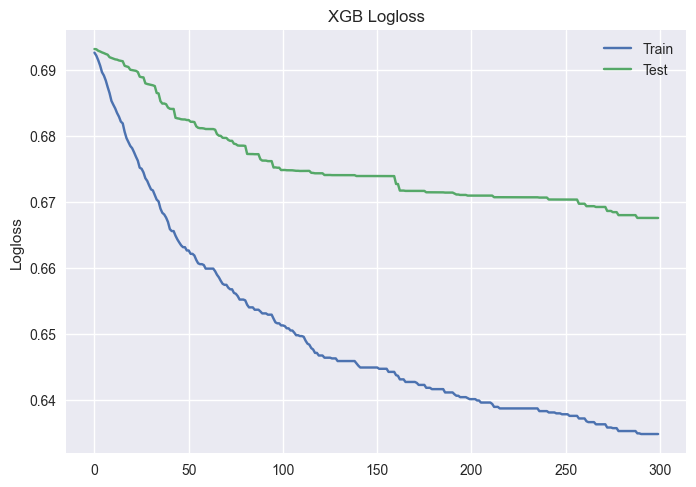

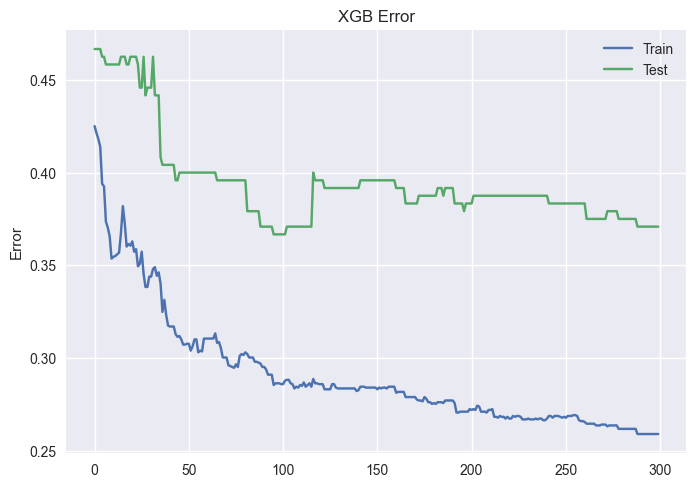

TRAIN:
Average Acc K-Fold 0.58
Std Dev K-Fold 0.04
Precision Score 0 0.716
Precision Score 1 0.771
----- ----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.53
Std Dev K-Fold 0.01
Precision Score 0 0.833
Precision Score 1 0.593



In [48]:
c.evaluation_metrics(scoring = "precision", plot_logloss = True, plot_error = True, print_results = True, ROC_curve = False)

<Figure size 2200x500 with 0 Axes>

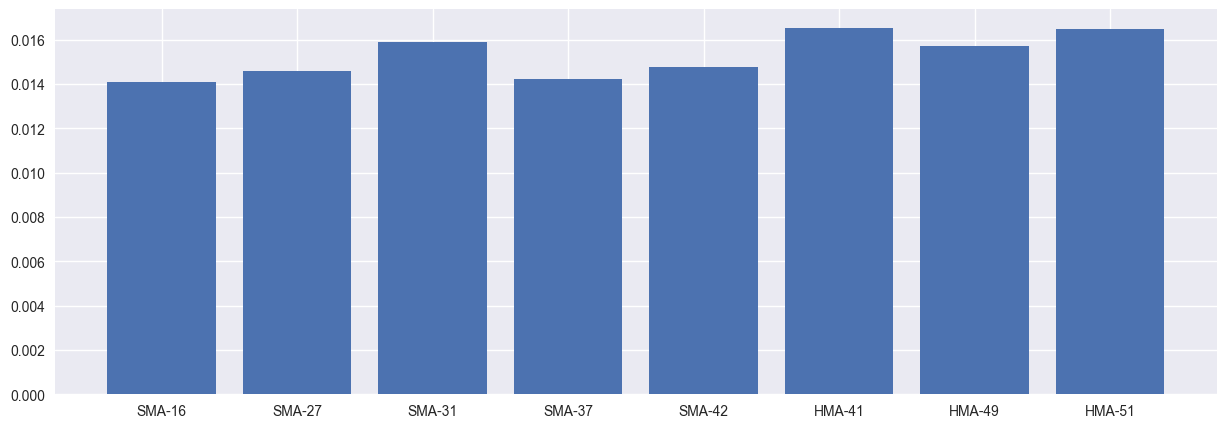

In [47]:
c.FeatureImportance(show_all = False, show_best = True, feature_importance = 0.014)